In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [0]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# #1 dummy

In [0]:
X = data.drop(["month", "day", 'area'], axis=1).astype(float)
y = data['area']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=17)

scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_valid_sc = scaler.transform(X_valid)

reg = SVR()
reg.fit(X_train_sc, y_train)
y_pred = reg.predict(X_valid_sc)
y_pred_train = reg.predict(X_train_sc)
metrics.mean_squared_error(y_valid, y_pred), \
metrics.mean_squared_error(y_train, y_pred_train)

(4763.681374610849, 3987.2077920540187)

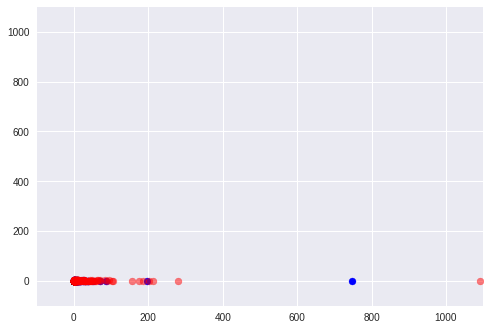

In [0]:
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(y_valid, y_pred, c='blue')
plt.scatter(y_train, y_pred_train, c='red', alpha=0.5)

# #2 добавляем категориальные переменные, фиксим выбросы

In [0]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
data.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),list(range(12)), inplace=True)
data.day.replace(('mon','tue','wed','thu','fri','sat','sun'),list(range(7)), inplace =True)
# data['is_weekend'] = data.day.apply(lambda x: 1 if x > 4 else 0)
# data['season'] = data.month // 3

X = data[data.area < 500].drop('area', axis=1)
y = np.log(1 + data[data.area < 500]['area'])


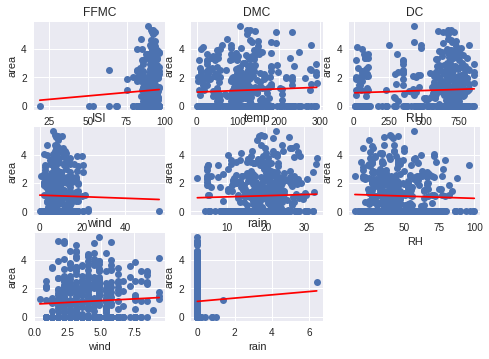

In [0]:
for i, col in enumerate([c for c in X.columns if c not in ['X', 'Y', 'month', 'day']]):
    plt.subplot(3, 3, i+1)
    x = X[col]
    y = y
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color = 'r')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('area')

я решил удалить вообще переменную rain и  два выброса по FFMC и ISI

In [0]:
cond = (X.FFMC > 25) & (X.ISI < 40)
X = X[cond]
y = y[cond]

X = pd.concat([
    X.drop(['X', 'Y', 'month' ,'day', 'rain'], axis=1),
    pd.get_dummies(X['day'], prefix='day'),
    pd.get_dummies(X['month'], prefix='month'),
    pd.get_dummies(X['X'], prefix='X'),
    pd.get_dummies(X['Y'], prefix='Y')
], axis=1)

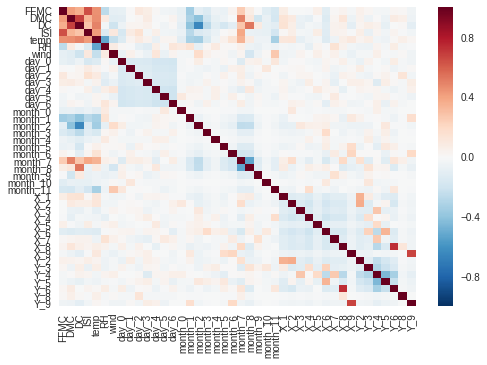

In [0]:
sns.heatmap(X.corr())

In [0]:
%%time
mse_train = []
mse_test = []
for i in range(1000):
    X_train, X_valid, y_train, y_valid = train_test_split(X.astype(float), y, test_size=.2)

    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_valid_sc = scaler.transform(X_valid)
    
    reg = SVR(gamma='auto')
    reg.fit(X_train_sc, y_train)
    y_pred = reg.predict(X_valid_sc)
    
    y_pred_train = reg.predict(X_train_sc)
    mse_test.append(metrics.mean_squared_error(y_valid, y_pred))
    mse_train.append(metrics.mean_squared_error(y_train, y_pred_train))

print(np.mean(mse_test), np.mean(mse_train))

2.136984764787344 1.3892669269680842
CPU times: user 47.6 s, sys: 10.7 ms, total: 47.6 s
Wall time: 47.7 s


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X.astype(float), y, test_size=.2, random_state=17)

scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_valid_sc = scaler.transform(X_valid)

reg = SVR()
reg.fit(X_train_sc, y_train)
y_pred = reg.predict(X_valid_sc)
y_pred_train = reg.predict(X_train_sc)
metrics.mean_squared_error(y_valid, y_pred), \
metrics.mean_squared_error(y_train, y_pred_train)

(2.2042677634164827, 1.4607729160796528)

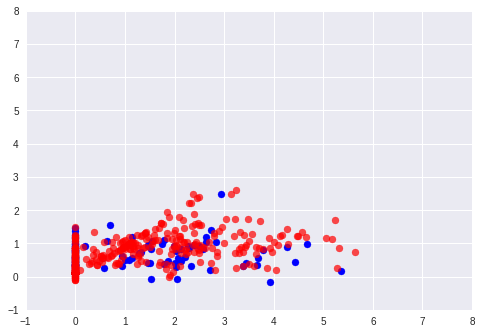

In [0]:
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.scatter(y_valid, y_pred, c='blue')
plt.scatter(y_train, y_pred_train, c='red', alpha=0.7)

In [0]:
%%time

param_grid = {
    "regression__kernel": ["linear", "poly", "rbf", "sigmoid"],
}
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', reg)], )
gs = GridSearchCV(pipeline, param_grid, 'neg_mean_squared_error', cv=4, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 128 ms, sys: 26.1 ms, total: 154 ms
Wall time: 2.19 s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
gs.best_params_

{'regression__kernel': 'rbf'}

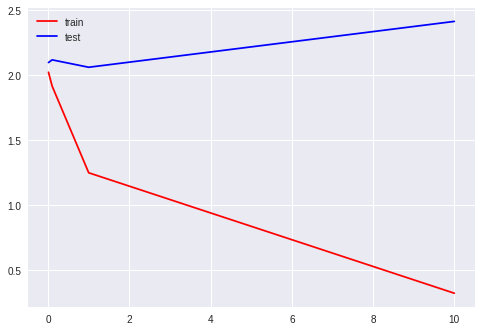

In [0]:
trains = []
tests = []
for i in np.logspace(-2, 1, 4):
    reg = SVR(kernel='rbf', C=i, gamma='auto')
    pipeline = Pipeline(steps = [('scaling', scaler), ('regression', reg)], )
    cv = cross_validate(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=4, return_train_score=True)
    trains.append(np.mean(cv['train_score'])*-1)
    tests.append(np.mean(cv['test_score'])*-1)

plt.plot( np.logspace(-2, 1, 4), trains, color='red', label='train')
plt.plot( np.logspace(-2, 1, 4), tests, color='blue', label='test')
plt.legend()
plt.show()

C=0.01

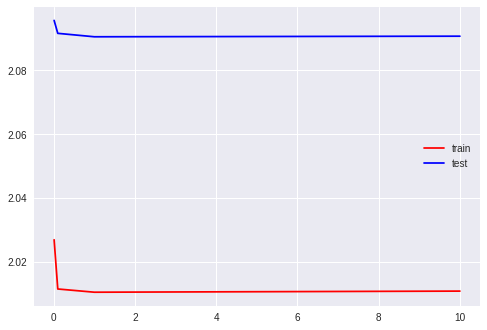

In [0]:
trains = []
tests = []
for i in np.logspace(-2, 1, 4):
    reg = SVR(kernel='rbf', C=1e-2, gamma=i)
    pipeline = Pipeline(steps = [('scaling', scaler), ('regression', reg)] )
    cv = cross_validate(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=4, return_train_score=True)
    trains.append(np.mean(cv['train_score'])*-1)
    tests.append(np.mean(cv['test_score'])*-1)

plt.plot( np.logspace(-2, 1, 4), trains, color='red', label='train')
plt.plot( np.logspace(-2, 1, 4), tests, color='blue', label='test')
plt.legend()
plt.show()

gamma = 0.1

In [0]:
%%time
mse_train = []
mse_test = []
for i in range(1000):
    X_train, X_valid, y_train, y_valid = train_test_split(X.astype(float), y, test_size=.2)

    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_valid_sc = scaler.transform(X_valid)
    
    reg = SVR(gamma=.1, C=.01, kernel='rbf')
    reg.fit(X_train_sc, y_train)
    y_pred = reg.predict(X_valid_sc)
    
    y_pred_train = reg.predict(X_train_sc)
    mse_test.append(metrics.mean_squared_error(y_valid, y_pred))
    mse_train.append(metrics.mean_squared_error(y_train, y_pred_train))

print(np.mean(mse_test), np.mean(mse_train))

2.35216243576736 2.2939876700278283
CPU times: user 43.5 s, sys: 5.05 ms, total: 43.5 s
Wall time: 43.5 s


Ну вот как-то так. Скейлинг + SVR с найденными параметрами итоговая модель.

еще я пробовал придумать разные фичи аля "выходной" или  "сезон", но ни одна rmse не улучшила, хотя на боксплотах разница была.